# Imports and packages

In [185]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Splitting the dataframe in two separate Frames - Categorical and Numerical

In [2]:
df = pd.read_csv('data/df_clean_engineered_all.csv')

In [26]:
# define number of important features
num_feats=20
y = df['churn']
X = df.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

In [4]:
cat_list = X.select_dtypes(exclude=['int', 'float']).columns
num_list = X.select_dtypes(include=['int', 'float']).columns

In [5]:
cat_list

Index(['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
       'zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede',
       'titel'],
      dtype='object')

In [6]:
# categroical dataframe
X_cat = X[cat_list]

In [7]:
X_cat.head()

,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,zahlung_weg_name,plz_1,plz_2,land_iso_code,anrede,titel
0,andere,ZEIT Digital,Probeabo,jährlich,Bankeinzug,6,64,DE,Frau,akademischer Titel
1,andere,ZEIT Digital,Probeabo,jährlich,Bankeinzug,6,64,DE,Frau,akademischer Titel
2,andere,ZEIT Digital,Probeabo,jährlich,Bankeinzug,6,64,DE,Frau,akademischer Titel
3,andere,ZEIT Digital,Festabo,jährlich,Bankeinzug,5,55,DE,Herr,kein Titel
4,andere,ZEIT Digital,Festabo,vierteljährlich,Bankeinzug,xx,xx,andere,Frau,kein Titel


In [8]:
X_cat_dum = pd.get_dummies(X_cat,drop_first=True)

In [9]:
X_cat_dum.head()

,kanal_B2B,kanal_E-Mailing,kanal_Eigenwerbung,kanal_Fremdwerbung,kanal_Mailings,kanal_SEA,kanal_Standwerbung,kanal_Telefonmarketing,kanal_andere,objekt_name_DIE ZEIT - CHRIST & WELT,...,plz_2_99,plz_2_xx,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0


In [10]:
# numerical dataframe
X_num = X[num_list]

In [11]:
X_num.head()

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,metropole,shop_kauf,unterbrechung,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,...,nl_clicked_1w,nl_clicked_1m,nl_clicked_3m,nl_clicked_6m,nl_unsubscribed_1w,nl_unsubscribed_1m,nl_unsubscribed_3m,nl_unsubscribed_6m,MONTH_DELTA_abo_min,MONTH_DELTA_nl_min
0,2013.833333,68,0,0,0,4,0,1.0,0,0,...,1,1,1,0,0,0,0,0,1279.233333,1287.433333
1,2013.833333,68,0,0,0,4,0,1.0,0,0,...,1,1,1,0,0,0,0,0,1279.233333,1287.433333
2,2013.833333,68,0,0,0,4,0,1.0,0,0,...,1,1,1,0,0,0,0,0,1279.233333,1287.433333
3,2013.833333,72,0,0,0,0,0,1.0,0,0,...,1,1,1,0,0,0,0,0,1385.233333,1385.200000
4,2013.750000,70,0,0,0,0,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0.000000,1383.033333


# Feature Importance for Categorical Features

In [186]:
# no scaling required
#X_X_cat_dum = pd.DataFrame(MinMaxScaler().fit_transform(X_cat_dum), columns=X_comb.columns, index=df.index)

## Person´s Correlation

In [27]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_cat_dum, y,num_feats)
print(str(len(cor_feature)), 'selected features')

20 selected features


## Chi Squared

In [28]:
#X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_cat_dum, y)
chi_support = chi_selector.get_support()
chi_feature = X_cat_dum.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

20 selected features


## Recursive

In [29]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_cat_dum, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_cat_dum.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 137 features.
Fitting estimator with 124 features.
Fitting estimator with 111 features.
Fitting estimator with 98 features.
Fitting estimator with 85 features.
Fitting estimator with 72 features.
Fitting estimator with 59 features.
Fitting estimator with 46 features.
Fitting estimator with 33 features.
20 selected features


## Model selected

### LogisticRegression

In [30]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_cat_dum, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_cat_dum.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

20 selected features


### RandomForest

In [31]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_cat_dum, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_cat_dum.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

20 selected features


## Conclusion

In [36]:
feature_name = X_cat_dum.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [39]:
feature_selection_df[0:40]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,zahlung_weg_name_Rechnung,True,True,True,True,True,5
2,objekt_name_ZEIT Digital,True,True,True,True,True,5
3,objekt_name_DIE ZEIT - CHRIST & WELT,True,True,True,True,True,5
4,kanal_andere,True,True,True,True,True,5
5,kanal_Mailings,True,True,True,True,True,5
6,kanal_B2B,True,True,True,True,True,5
7,zahlung_rhythmus_name_vierteljährlich,True,True,True,False,True,4
8,zahlung_rhythmus_name_halbjährlich,True,True,True,False,True,4
9,aboform_name_Geschenkabo,True,True,False,True,True,4
10,zahlung_rhythmus_name_jährlich,True,True,False,False,True,3


In [96]:
feature_selection_df_cat= pd.read_csv('ml_results/feature_importance_categorical_all_features.csv')

In [97]:
important_features_cat = feature_selection_df_cat[feature_selection_df_cat['Total'] >= 3].Feature.to_list()

In [98]:
important_features_cat

['zahlung_weg_name_Rechnung',
 'objekt_name_ZEIT Digital',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'kanal_andere',
 'kanal_Mailings',
 'kanal_B2B',
 'zahlung_rhythmus_name_vierteljährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'aboform_name_Geschenkabo',
 'zahlung_rhythmus_name_jährlich',
 'titel_sonstiger Titel',
 'land_iso_code_DE',
 'kanal_Telefonmarketing',
 'kanal_Eigenwerbung',
 'kanal_E-Mailing',
 'anrede_Herr',
 'anrede_Frau',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option']

<AxesSubplot:>

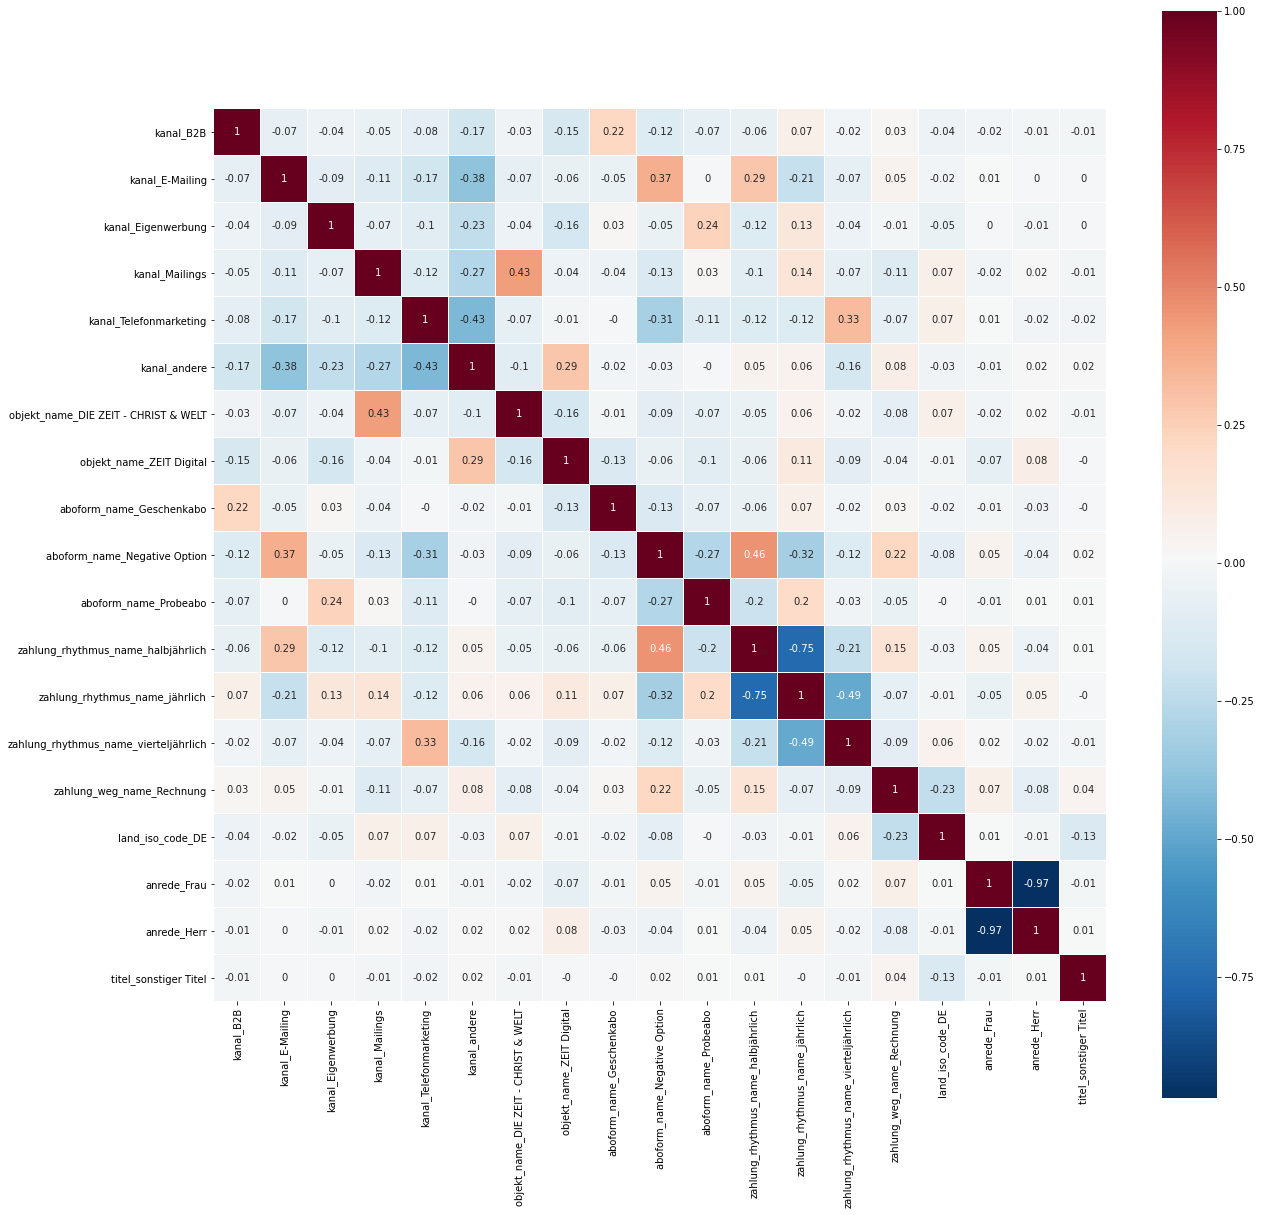

In [102]:
correlogram_categorical_features = X_cat_dum[X_cat_dum.columns.intersection(important_features_cat)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_categorical_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=True)

In [187]:
# drop anrede frau, zahlung rythmus halbjaehrig?

# Feature Importance for Numerical Features

In [188]:
# scaling required
X_num = pd.DataFrame(MinMaxScaler().fit_transform(X_num), columns=X_num.columns, index=df.index)

## Person´s Correlation

In [189]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_num, y,num_feats)
print(str(len(cor_feature)), 'selected features')

40 selected features


## Chi Squared

In [190]:
#X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_num, y)
chi_support = chi_selector.get_support()
chi_feature = X_num.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


## Recursive

In [191]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_num, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_num.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 170 features.
Fitting estimator with 153 features.
Fitting estimator with 136 features.
Fitting estimator with 119 features.
Fitting estimator with 102 features.
Fitting estimator with 85 features.
Fitting estimator with 68 features.
Fitting estimator with 51 features.
40 selected features


## Model selected

### LogisticRegression

In [192]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_num, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_num.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

40 selected features


### RandomForest

In [193]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_num, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_num.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

33 selected features


## Conclusion + Correlation

In [195]:
feature_name = X_num.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [196]:
feature_selection_df[0:40]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,received_anzahl_6m,True,True,True,True,True,5
2,received_anzahl_1w,True,True,True,True,True,5
3,openedanzahl_6m,True,True,True,True,True,5
4,nl_aktivitaet,True,True,True,True,True,5
5,liefer_beginn_evt,True,True,True,True,True,5
6,lesedauer,True,True,True,True,True,5
7,cnt_umwandlungsstatus2_dkey,True,True,True,True,True,5
8,shop_kauf,True,False,True,True,True,4
9,received_anzahl_bestandskunden_3m,True,True,True,True,False,4
10,opened_anzahl_3m,True,False,True,True,True,4


In [197]:
feature_selection_df.to_csv('ml_results/feature_importance_numerical_all_features.csv')

In [198]:
important_features = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [199]:
important_features

['received_anzahl_6m',
 'received_anzahl_1w',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'cnt_umwandlungsstatus2_dkey',
 'shop_kauf',
 'received_anzahl_bestandskunden_3m',
 'opened_anzahl_3m',
 'opened_anzahl_1w',
 'clicked_anzahl_6m',
 'clicked_anzahl_3m',
 'MONTH_DELTA_nl_min',
 'sum_zon',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_3m',
 'received_anzahl_1m',
 'openrate_zeitbrief_3m',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'metropole']

<AxesSubplot:>

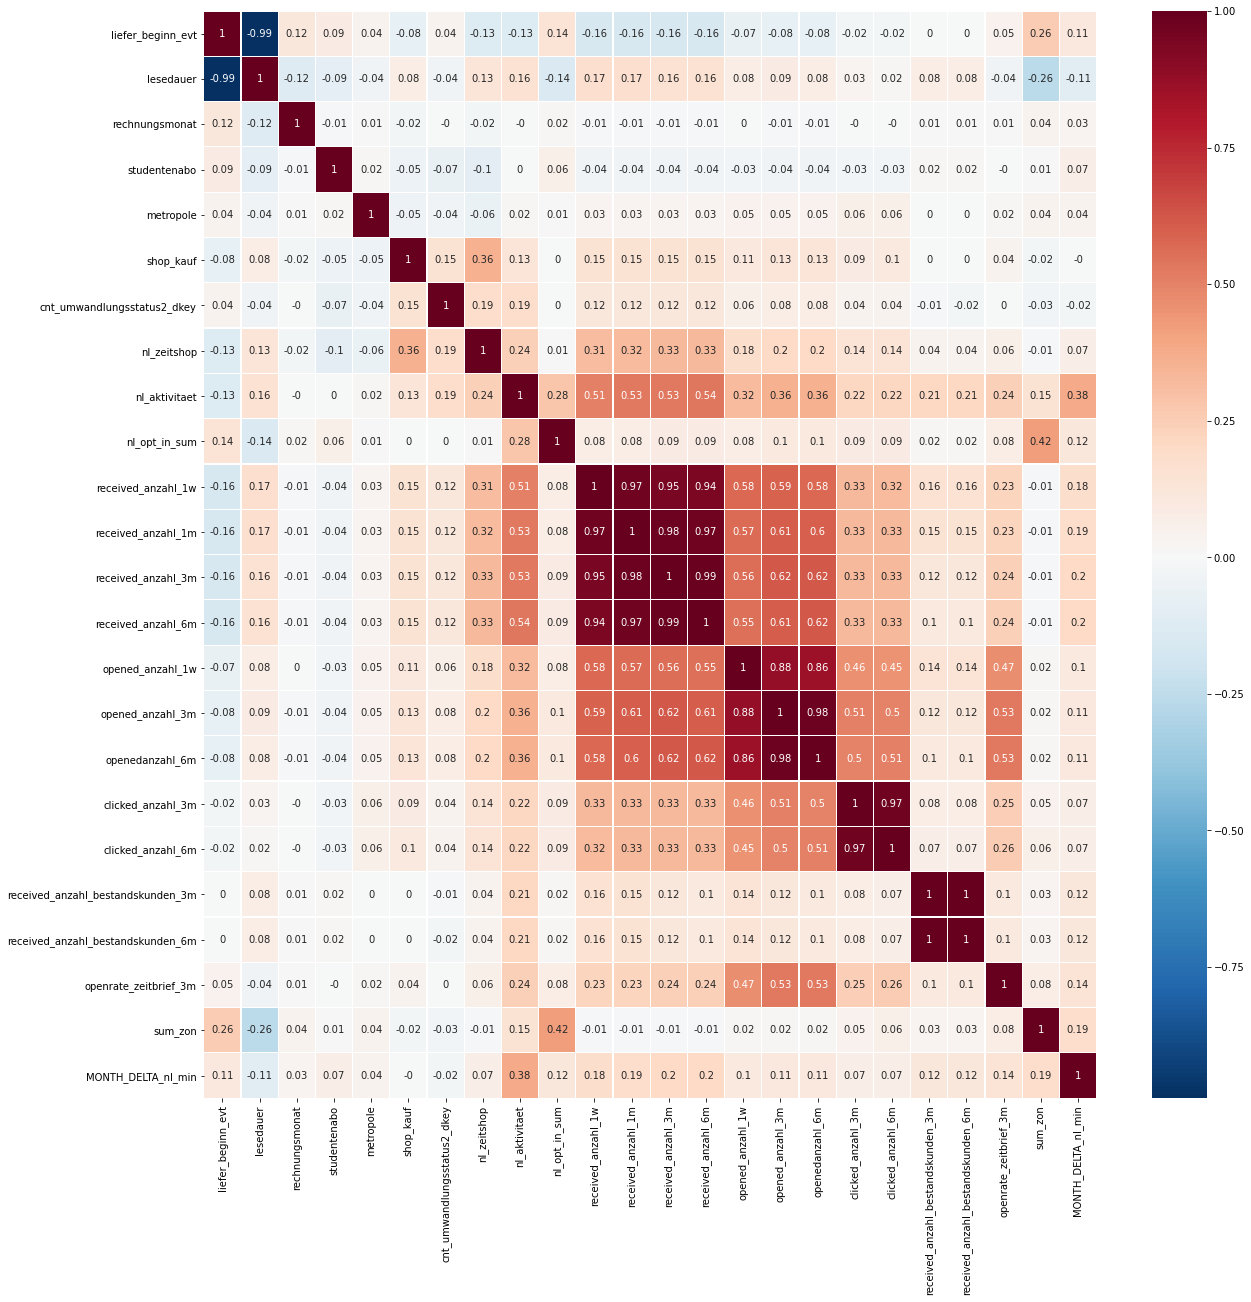

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
correlogram_numerical_features = X_num[X_num.columns.intersection(important_features)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_numerical_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [201]:
removelist1 = ['lesedauer','opened_anzahl_3m','opened_anzahl_1m','opened_anzahl_1w','received_anzahl_1w','received_anzahl_1m','received_anzahl_3m','clicked_anzahl_3m']

important_features2 = [i for i in important_features if i not in removelist1]

<AxesSubplot:>

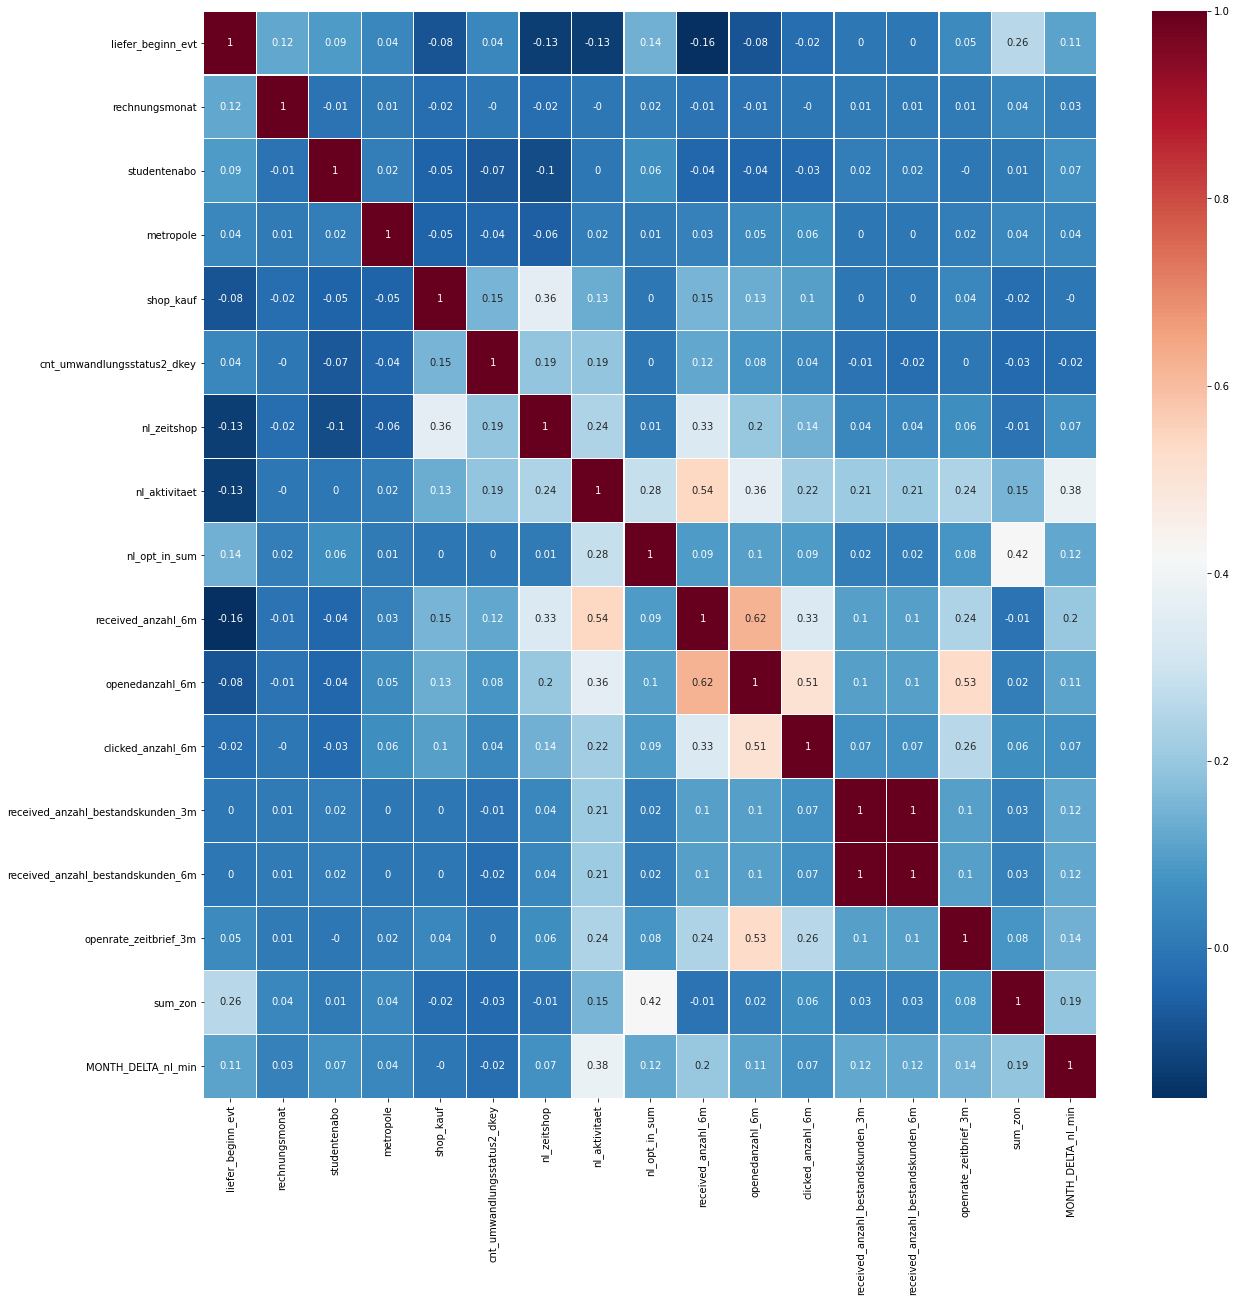

In [202]:
correlogram_numerical_features2 = X_num[X_num.columns.intersection(important_features2)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_numerical_features2.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [111]:
removelist2 = ['sso_reg']

important_features3 = [i for i in important_features2 if i not in removelist2]

<AxesSubplot:>

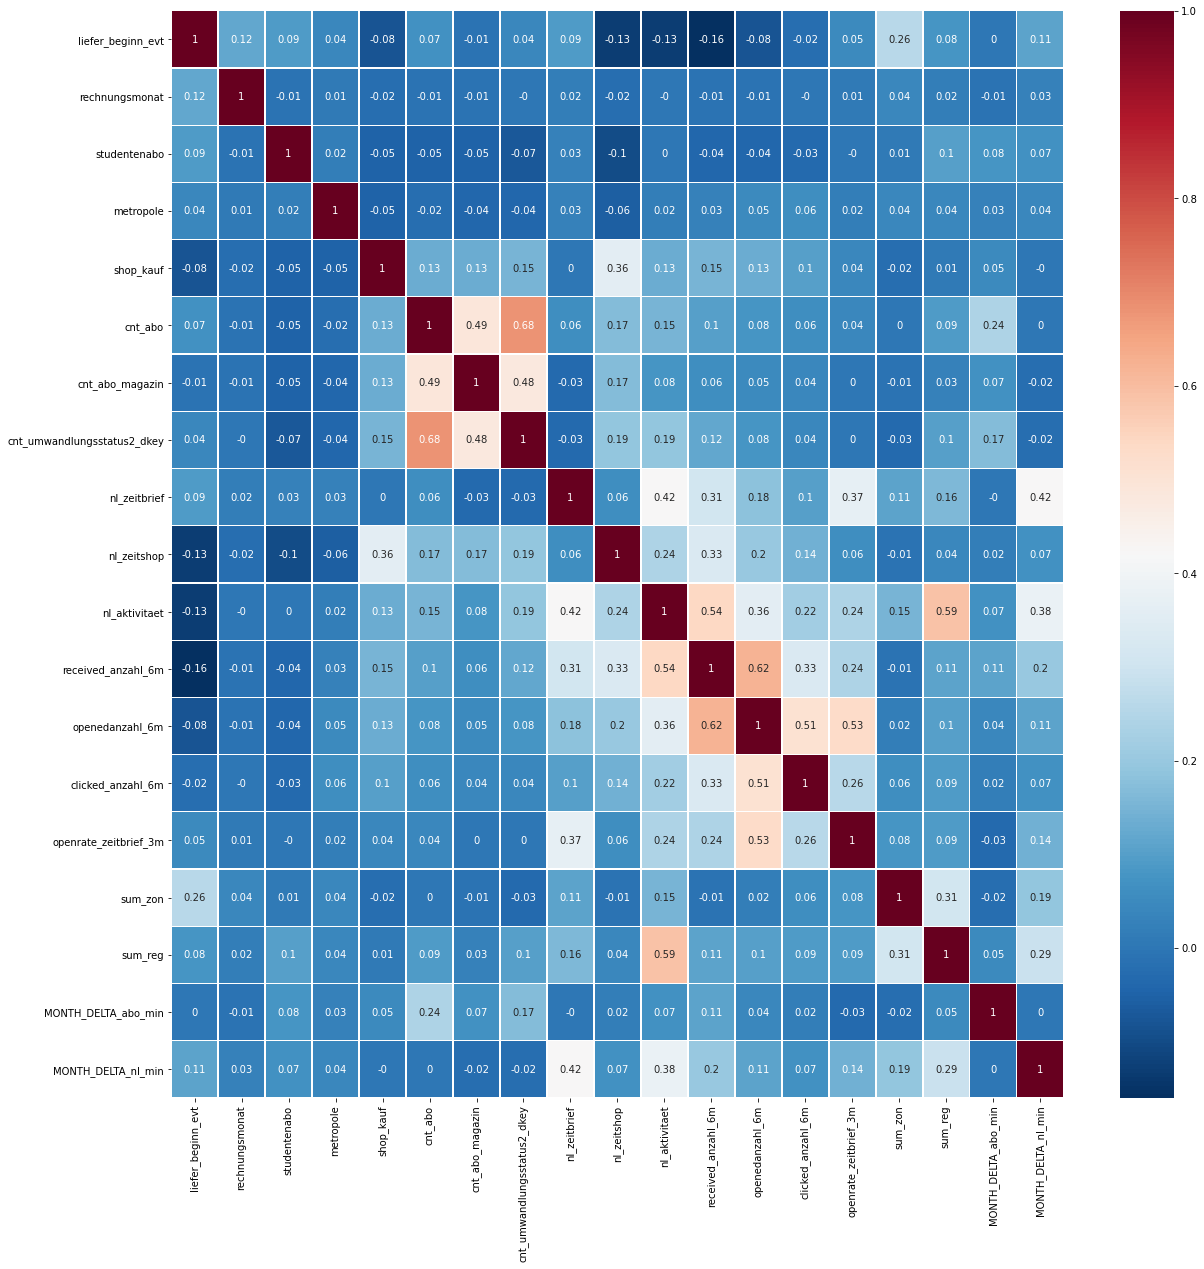

In [112]:
correlogram_numerical_features3 = X_num[X_num.columns.intersection(important_features3)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_numerical_features3.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [203]:
important_features3

['studentenabo',
 'rechnungsmonat',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'cnt_umwandlungsstatus2_dkey',
 'shop_kauf',
 'received_anzahl_6m',
 'nl_zeitshop',
 'cnt_abo_magazin',
 'clicked_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'openrate_zeitbrief_3m',
 'nl_zeitbrief',
 'metropole',
 'liefer_beginn_evt',
 'cnt_abo',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']

# Feature importance by simple Random Forest

In [205]:
X_RF = pd.concat([X_cat_dum,X_num], axis=1)

In [206]:
RF = RandomForestClassifier(n_jobs=-1)

model = RF.fit(X_RF, y)

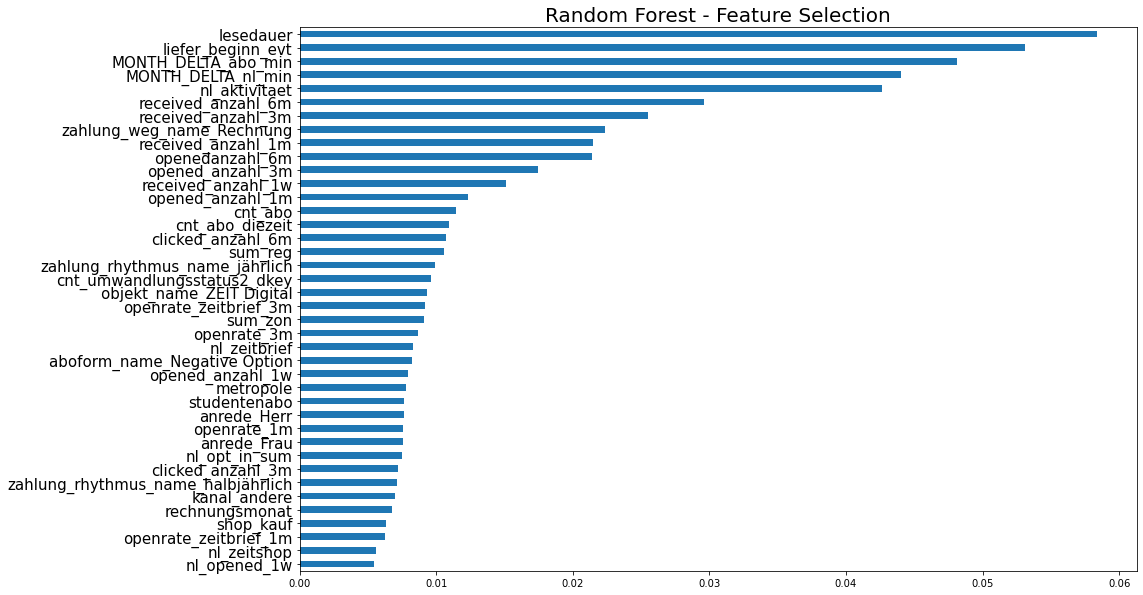

In [209]:
pd.Series(model.feature_importances_, index=X_RF.columns).nlargest(40).plot(kind='barh', figsize=(15,10)).invert_yaxis();

plt.yticks(size=15);
plt.title('Random Forest - Feature Selection', size=20);

# Feature Importance for Combined Features

## Person´s Correlation

In [146]:
X_comb = pd.concat([X_cat_dum,X_num],axis=1)

In [147]:
X_comb.shape

(184660, 307)

In [152]:
X_comb_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_comb), columns=X_comb.columns, index=df.index)

In [153]:
X_comb_scaled.head(5)

,kanal_B2B,kanal_E-Mailing,kanal_Eigenwerbung,kanal_Fremdwerbung,kanal_Mailings,kanal_SEA,kanal_Standwerbung,kanal_Telefonmarketing,kanal_andere,objekt_name_DIE ZEIT - CHRIST & WELT,...,nl_clicked_1w,nl_clicked_1m,nl_clicked_3m,nl_clicked_6m,nl_unsubscribed_1w,nl_unsubscribed_1m,nl_unsubscribed_3m,nl_unsubscribed_6m,MONTH_DELTA_abo_min,MONTH_DELTA_nl_min
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.880126,0.877177
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.880126,0.877177
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.880126,0.877177
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.953055,0.943790
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.00,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.942313


In [134]:
num_feats=40

In [154]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_comb_scaled, y,num_feats)
print(str(len(cor_feature)), 'selected features')

40 selected features


## Chi Squared

In [155]:
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_comb_scaled, y)
chi_support = chi_selector.get_support()
chi_feature = X_comb_scaled.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


## Recursive

In [156]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_comb_scaled, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_comb_scaled.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 307 features.
Fitting estimator with 277 features.
Fitting estimator with 247 features.
Fitting estimator with 217 features.
Fitting estimator with 187 features.
Fitting estimator with 157 features.
Fitting estimator with 127 features.
Fitting estimator with 97 features.
Fitting estimator with 67 features.
40 selected features


## Model selected

### LogisticRegression

In [157]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_comb_scaled, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_comb_scaled.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

40 selected features


### RandomForest

In [158]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_comb_scaled, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_comb_scaled.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

40 selected features


## Conclusion

In [159]:
feature_name = X_comb.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [160]:
feature_selection_df[0:40]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,zahlung_weg_name_Rechnung,True,True,True,True,True,5
2,nl_aktivitaet,True,True,True,True,True,5
3,liefer_beginn_evt,True,True,True,True,True,5
4,lesedauer,True,True,True,True,True,5
5,zahlung_rhythmus_name_jährlich,True,True,False,True,True,4
6,received_anzahl_6m,True,False,True,True,True,4
7,received_anzahl_1w,True,False,True,True,True,4
8,openedanzahl_6m,True,False,True,True,True,4
9,opened_anzahl_3m,True,False,True,True,True,4
10,opened_anzahl_1w,True,False,True,True,True,4


|    | Feature                               | Pearson   | Chi-2   | RFE   | Logistics   | Random Forest   |   Total |
|---:|:--------------------------------------|:----------|:--------|:------|:------------|:----------------|--------:|
|  1 | zahlung_weg_name_Rechnung             | True      | True    | True  | True        | True            |       5 |
|  2 | nl_aktivitaet                         | True      | True    | True  | True        | True            |       5 |
|  3 | liefer_beginn_evt                     | True      | True    | True  | True        | True            |       5 |
|  4 | lesedauer                             | True      | True    | True  | True        | True            |       5 |
|  5 | zahlung_rhythmus_name_jährlich        | True      | True    | False | True        | True            |       4 |
|  6 | received_anzahl_6m                    | True      | False   | True  | True        | True            |       4 |
|  7 | received_anzahl_1w                    | True      | False   | True  | True        | True            |       4 |
|  8 | openedanzahl_6m                       | True      | False   | True  | True        | True            |       4 |
|  9 | opened_anzahl_3m                      | True      | False   | True  | True        | True            |       4 |
| 10 | opened_anzahl_1w                      | True      | False   | True  | True        | True            |       4 |
| 11 | objekt_name_DIE ZEIT - CHRIST & WELT  | True      | True    | True  | True        | False           |       4 |
| 12 | clicked_anzahl_6m                     | True      | False   | True  | True        | True            |       4 |
| 13 | clicked_anzahl_3m                     | True      | False   | True  | True        | True            |       4 |
| 14 | zahlung_rhythmus_name_halbjährlich    | True      | True    | False | False       | True            |       3 |
| 15 | studentenabo                          | True      | True    | False | False       | True            |       3 |
| 16 | rechnungsmonat                        | True      | True    | False | False       | True            |       3 |
| 17 | received_anzahl_bestandskunden_6m     | True      | True    | True  | False       | False           |       3 |
| 18 | received_anzahl_bestandskunden_3m     | True      | True    | True  | False       | False           |       3 |
| 19 | openrate_zeitbrief_3m                 | False     | False   | True  | True        | True            |       3 |
| 20 | openrate_zeitbrief_1m                 | False     | False   | True  | True        | True            |       3 |
| 21 | objekt_name_ZEIT Digital              | True      | True    | False | False       | True            |       3 |
| 22 | nl_zeitshop                           | True      | True    | False | False       | True            |       3 |
| 23 | nl_opt_in_sum                         | False     | False   | True  | True        | True            |       3 |
| 24 | land_iso_code_DE                      | True      | False   | True  | True        | False           |       3 |
| 25 | cnt_umwandlungsstatus2_dkey           | True      | True    | False | False       | True            |       3 |
| 26 | anrede_Herr                           | True      | True    | False | False       | True            |       3 |
| 27 | anrede_Frau                           | True      | True    | False | False       | True            |       3 |
| 28 | aboform_name_Negative Option          | True      | True    | False | False       | True            |       3 |
| 29 | MONTH_DELTA_nl_min                    | False     | False   | True  | True        | True            |       3 |
| 30 | MONTH_DELTA_abo_min                   | False     | False   | True  | True        | True            |       3 |
| 31 | zahlung_rhythmus_name_zweijährlich    | False     | False   | True  | True        | False           |       2 |
| 32 | zahlung_rhythmus_name_vierteljährlich | True      | True    | False | False       | False           |       2 |
| 33 | unsubscribed_anzahl_6m                | False     | False   | True  | True        | False           |       2 |
| 34 | unsubscribed_anzahl_3m                | False     | False   | True  | True        | False           |       2 |
| 35 | unsubscribed_anzahl_1w                | False     | False   | True  | True        | False           |       2 |
| 36 | unsubscribed_anzahl_1m                | False     | False   | True  | True        | False           |       2 |
| 37 | sum_zon                               | True      | False   | False | False       | True            |       2 |
| 38 | sum_reg                               | False     | False   | True  | False       | True            |       2 |
| 39 | sso_reg                               | True      | True    | False | False       | False           |       2 |
| 40 | shop_kauf                             | True      | False   | False | False       | True            |       2 |

## Reducing correlated features from the set

In [161]:
important_features_combined_scale = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [162]:
important_features_combined_scale

['zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'zahlung_rhythmus_name_jährlich',
 'received_anzahl_6m',
 'received_anzahl_1w',
 'openedanzahl_6m',
 'opened_anzahl_3m',
 'opened_anzahl_1w',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'clicked_anzahl_6m',
 'clicked_anzahl_3m',
 'zahlung_rhythmus_name_halbjährlich',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'openrate_zeitbrief_3m',
 'openrate_zeitbrief_1m',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'land_iso_code_DE',
 'cnt_umwandlungsstatus2_dkey',
 'anrede_Herr',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']

<AxesSubplot:>

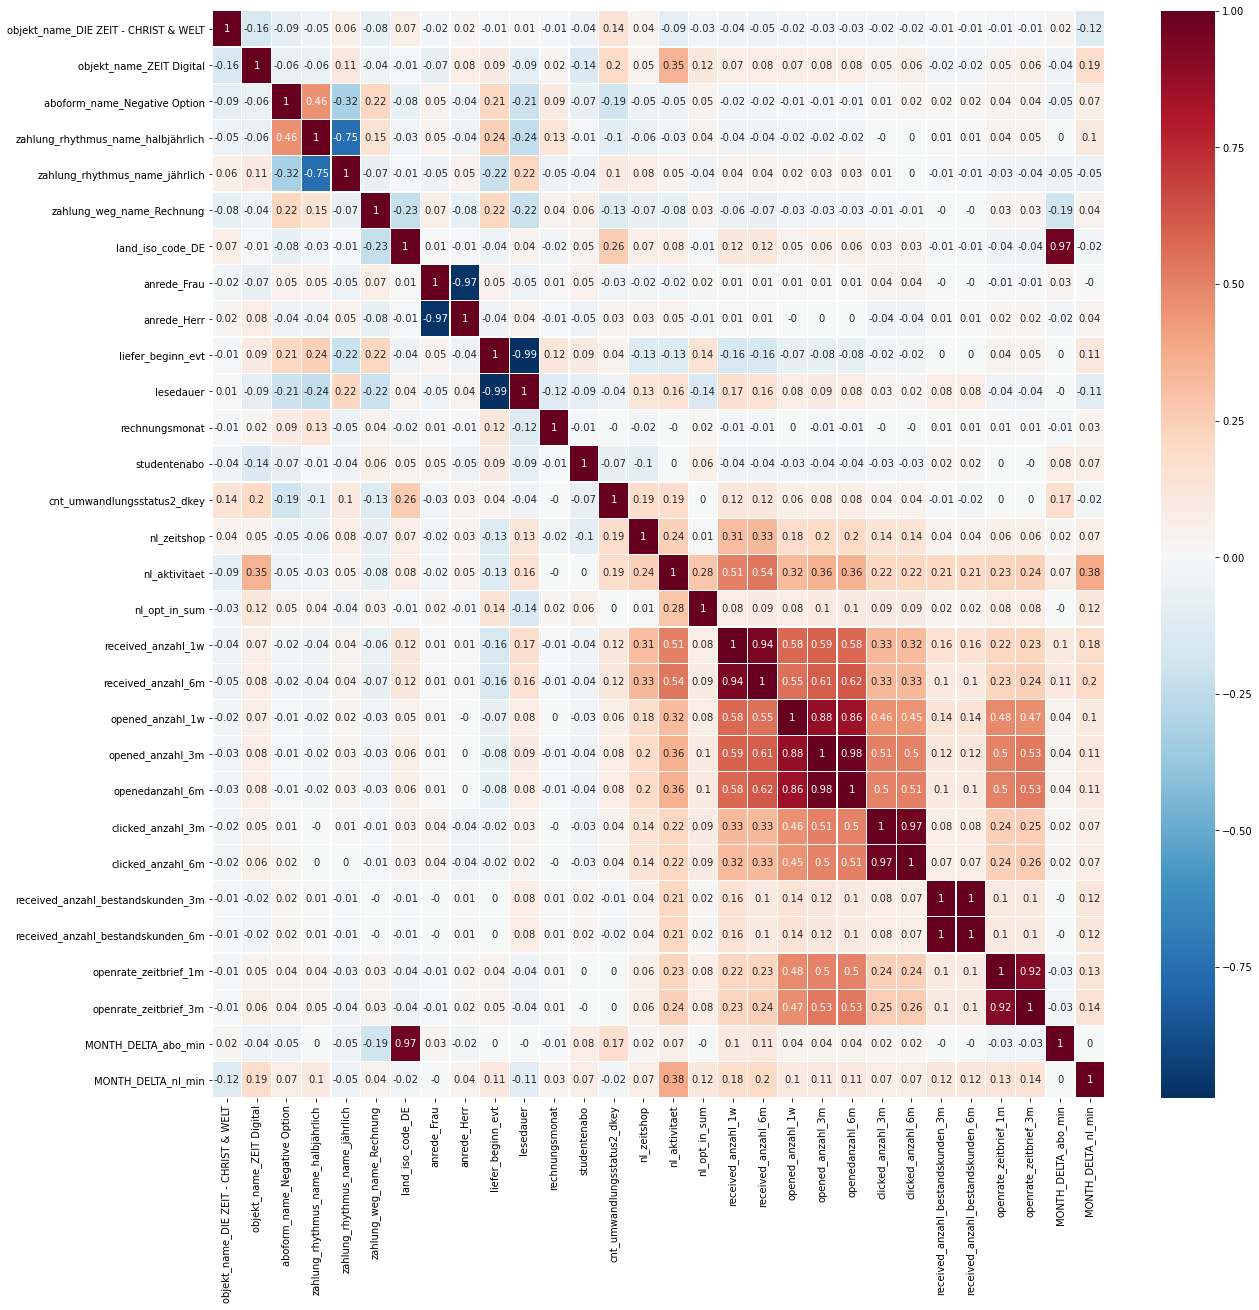

In [172]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features_combined_scale)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [178]:
removelist1 = ['lesedauer','anrede_Herr','received_anzahl_1w','received_anzahl_1w','opened_anzahl_3m','opened_anzahl_1w','clicked_anzahl_3m','openrate_zeitbrief_1m','land_iso_code_DE','zahlung_rhythmus_name_jährlich']

important_features2 = [i for i in important_features_combined_scale if i not in removelist1]
important_features2

['zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'clicked_anzahl_6m',
 'zahlung_rhythmus_name_halbjährlich',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'openrate_zeitbrief_3m',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'cnt_umwandlungsstatus2_dkey',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']

<AxesSubplot:>

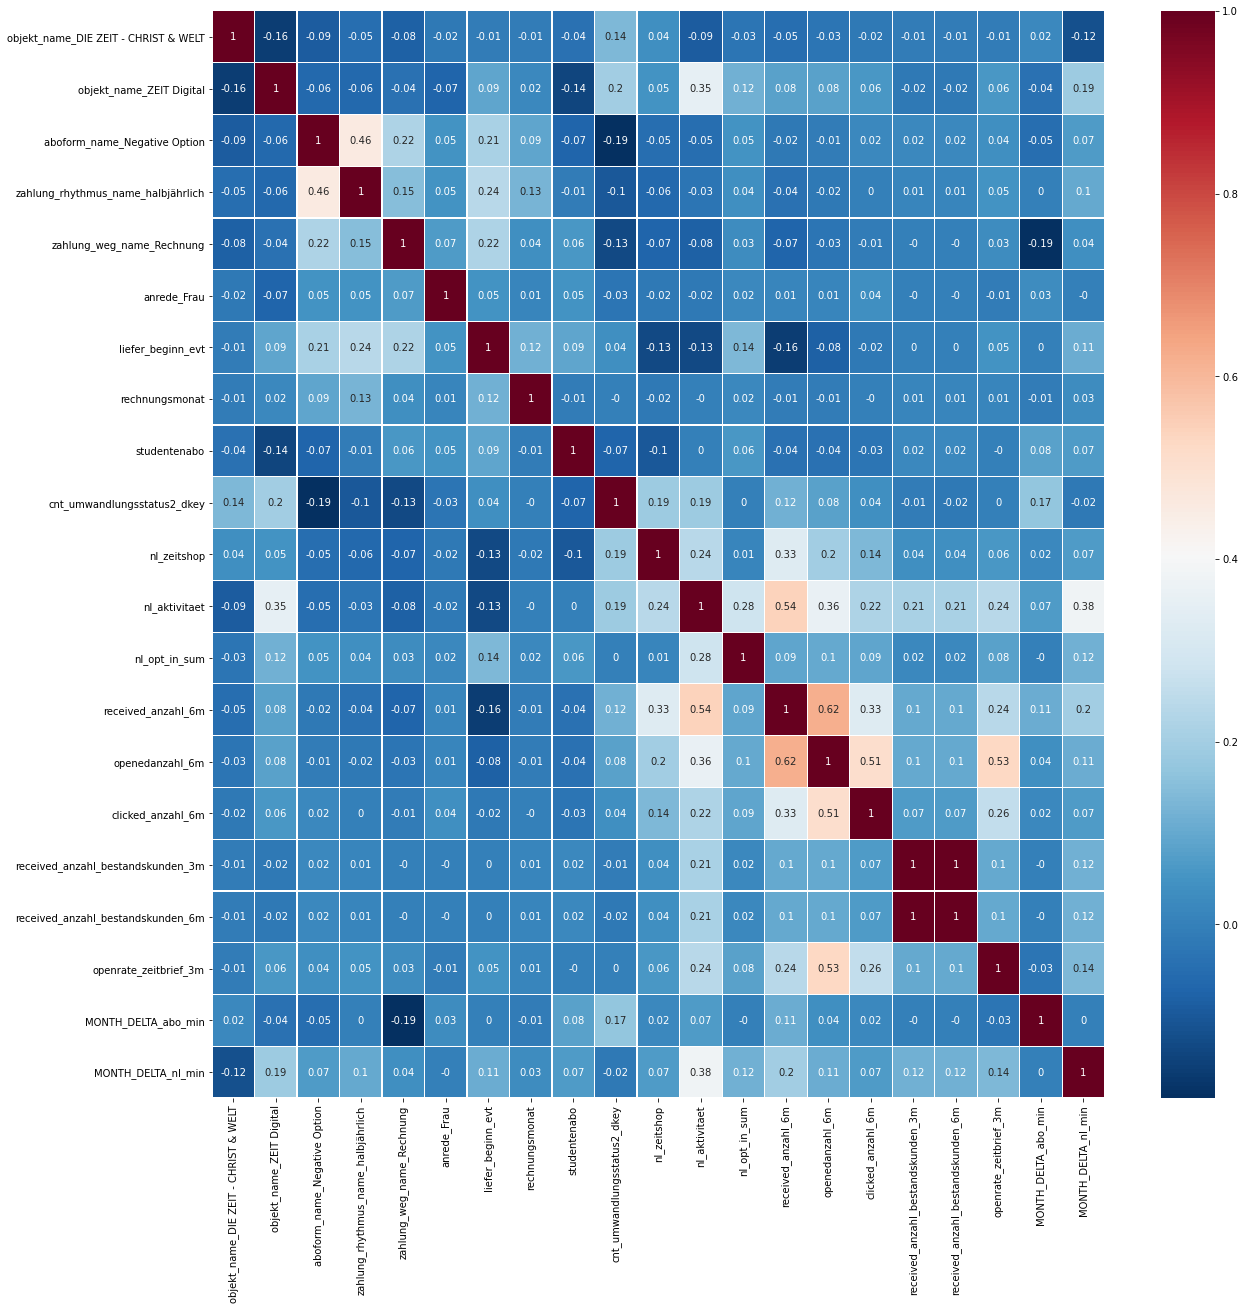

In [179]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features2)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

### Final Feature Selection List:

In [180]:
important_features2

['zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'clicked_anzahl_6m',
 'zahlung_rhythmus_name_halbjährlich',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'openrate_zeitbrief_3m',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'cnt_umwandlungsstatus2_dkey',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']

['zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'clicked_anzahl_6m',
 'zahlung_rhythmus_name_halbjährlich',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'openrate_zeitbrief_3m',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'cnt_umwandlungsstatus2_dkey',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']